# Degeneracy analysis

__Définition:__ L'estimateur de Kraskov de l'entropie différentielle échoue lorsque les données possèdent des échantillons identiques ou très proches i.e. des diracs dans la densité de probabilité. Ces valeurs sont dites dégénérées.

__Objectifs:__
* Illustrer le phénomène de dégénérescence dans le calcul de l'entropie différentielle par l'estimateur de Kraskov.
* Etudier l'impact d'un bruit additif gaussien sur la valeur de l'entropie et sur les dégénérescences.
* Identifier les potentielles dégénérescences dans les paramètres physiques.
* Estimer une valeur adéquate pour l'écart type du bruit additif gaussien pour résoudre ces dégénérescences.

In [2]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.abspath(""), "..", ".."))

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from infovar.stats import entropy_estimators as ee

base = 2

## Two types of degeneracy

En float 32, qui est le format par défaut des librairies de calcul numérique, le nombre de valeurs possibles est de plus de $4\times10^9$. Etant donné que le nombre d'échantillons utilisés pour un calcul d'entropie ou d'information mutuelle est systématiquement largement inférieur, la probabilité d'avoir des doublons est proche de zéro.

Dans les données réelles, ce n'est cependant souvent pas le cas, et ce pour plusieurs raisons:
1. Les données sont quantifiées sur moins de valeurs, par exemple entrées avec 2 chiffres après la virgule.
2. Les données sont bien des float 32, cependant certaines valeurs sont exactement identiques (par exemple pour des raisons de saturation)

Le cas 1 peut-être géré en ajoutant un bruit uniforme dont la taille du support correspond au pas d'échantillonnage. Exemple, si les données sont arrondies à 2 chiffres après la virgules, alors on ajoute un bruit uniforme sur $\left]-\frac12\,10^{-2},\,\frac12\,10^{-2}\right[$.

Le second cas peut-être géré en ajoutant un bruit aux échantillons. Cependant, la dynamique de ce bruit est assez critique car, si ce dernier est trop faible, alors les doublons vont dominer. Inversement, si le bruit est trop élevé, alors ce sera lui qui dominera.

## Case of discrete data (1)

In [34]:
rho = 0.8
sigmax, sigmay = 2, 1

def get_data(n_samples: int):
    mus = np.array([0, 0])
    sigmas = np.array([[sigmax**2, sigmax*sigmay*rho], [sigmax*sigmay*rho, sigmay**2]])

    data = np.random.multivariate_normal(mus, sigmas, size=n_samples)
    # x = data[:, 0].reshape(-1, 1)
    # y = data[:, 1].reshape(-1, 1)
    # return x, y
    return data

n_samples = 10_000
n_fig = 2

datac = get_data(n_samples)
datad = np.round(datac, n_fig)
datadc = datad + (np.random.random(size=datad.shape)-0.5) * 10**(-n_fig)

In [35]:
ee.entropy(datac[:, 0].reshape(-1, 1)),\
    ee.entropy(datad[:, 0].reshape(-1, 1)),\
        ee.entropy(datadc[:, 0].reshape(-1, 1))

(3.0589442464806957, -21.961659135096568, 3.0422588811982756)

In [36]:
ee.mi(datac[:, 0].reshape(-1, 1), datac[:, 1].reshape(-1, 1)),\
    ee.mi(datad[:, 0].reshape(-1, 1), datac[:, 1].reshape(-1, 1)),\
        ee.mi(datadc[:, 0].reshape(-1, 1), datac[:, 1].reshape(-1, 1))

(0.7447210914979396, 0.7457655804480061, 0.7491636813647745)

## Case of continuous data with duplicates (2)

In [ ]:
# TODO

## Analytical example

How we count the duplicates: the number of duplicates is the number of values that already exist in the data. For instance, in the following list, we have:

[1, 2, 2, 3, 4, 1, 2]

the values 2 and 1 that appear several times. We say that the other values 3 and 4 has no duplicates. 2 has 2 duplicates and 3 has 1 duplicates.
The fraction of duplicates is the number of duplicates (i.e. the lenght of the set representing the list), here 2+1=3 divided by the total number of elements: 3/7 ~ 42.8%.

In [2]:
def degenerate(data: np.ndarray, frac: float) -> np.ndarray:
    """Returns a modified version of the array`data` with a fraction `frac` of duplicated elements. For instance, if `frac=0.5`, half of the array values are duplicates."""
    
    n = data.shape[0]
    m = round(frac * n)

    idx = np.arange(n)

    if frac > 1 or frac < 0:
        raise ValueError("frac must be within the interval [0, 1]")
    if m == 0:
        return data
    if m >= n-1:
        i = np.random.choice(idx, 1)
        return np.zeros_like(data) + data[i]

    idx_to_change = np.random.choice(idx, m, replace=False)
    idx_to_keep = idx[~np.isin(idx, idx_to_change)]
    
    new_data = data.copy()
    new_data[idx_to_change] = data[np.random.choice(idx_to_keep, m)]
    return new_data

def entropy_normal(sigma: float, base: float=2):
    return 0.5 * np.log(2*np.pi*np.e*sigma**2) / np.log(base)

def mi_bivariate_normal(rho: float, base: float=2):
    return - 0.5 * np.log(1 - rho**2) / np.log(base)

### Data

In [3]:
n_samples = 100_000
sigma = 1

data = np.random.normal(0, sigma, n_samples)
data = data.reshape(-1, 1)

### Influence of the fraction of duplicates

In [4]:
fracs = np.linspace(0, 1, 200)

hs_degen = np.zeros_like(fracs)
for i, frac in enumerate(tqdm(fracs)):
    data_degen = degenerate(data, frac)
    hs_degen[i] = ee.entropy(data_degen, base=base)

h = ee.entropy(data, base=base)
href = entropy_normal(sigma, base=base)

100%|█████████▉| 199/200 [00:30<00:00,  6.61it/s]/users/astro/einig/Python/infovar/examples/assessment/../../infovar/stats/entropy_estimators.py:66: RuntimeWarning: divide by zero encountered in log
  return (const + n_features * np.log(nn).mean()) / log(base)
100%|██████████| 200/200 [00:30<00:00,  6.60it/s]


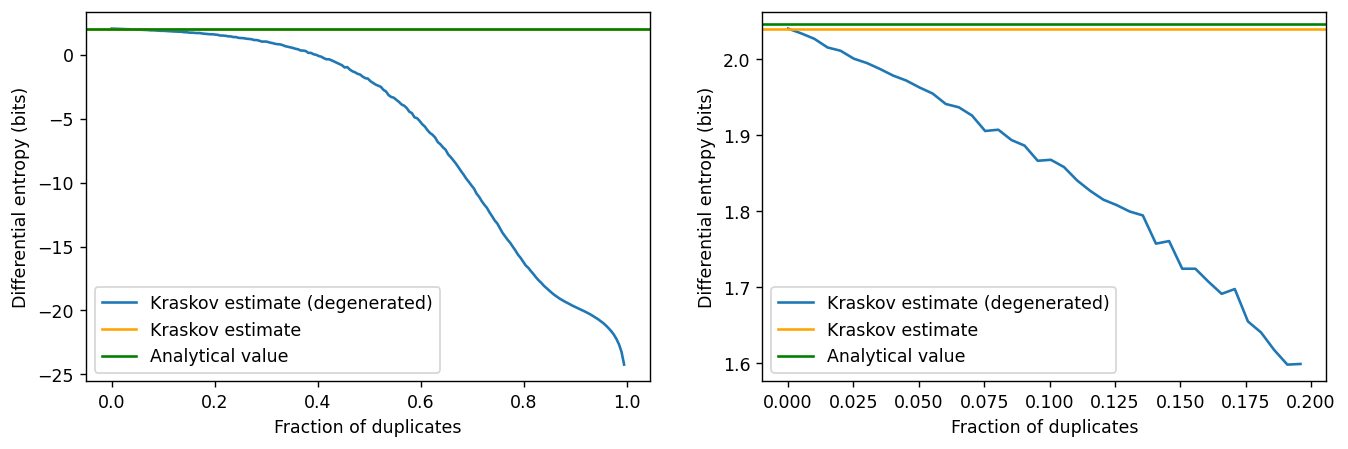

In [5]:
plt.figure(figsize=(2*6.4, 0.8*4.8), dpi=125)

plt.subplot(1, 2, 1)

plt.plot(fracs, hs_degen, label='Kraskov estimate (degenerated)')
plt.axhline(h, color='orange', label='Kraskov estimate')
plt.axhline(href, color='green', label='Analytical value')

plt.xlabel('Fraction of duplicates')
plt.ylabel('Differential entropy (bits)')
plt.legend()

plt.subplot(1, 2, 2)

filt = fracs < 0.2
plt.plot(fracs[filt], hs_degen[filt], label='Kraskov estimate (degenerated)')
plt.axhline(h, color='orange', label='Kraskov estimate')
plt.axhline(href, color='green', label='Analytical value')

plt.xlabel('Fraction of duplicates')
plt.ylabel('Differential entropy (bits)')
plt.legend()

plt.show()

### Impact of an additive Gaussian noise on degeneracy

In [6]:
fracs = [0.01, 0.1, 0.2, 0.5]
stds = np.logspace(-6, 1, 200)

hs_degen_list = []
for frac in fracs:
    hs_degen = np.zeros_like(stds)
    for i, std in enumerate(tqdm(stds)):
        data_degen = degenerate(data, frac)
        data_degen += np.random.normal(0, std, data.shape)
        hs_degen[i] = ee.entropy(data_degen, base=base)
    hs_degen_list.append(hs_degen)

h = ee.entropy(data, base=base)
href = entropy_normal(sigma, base=base)

100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


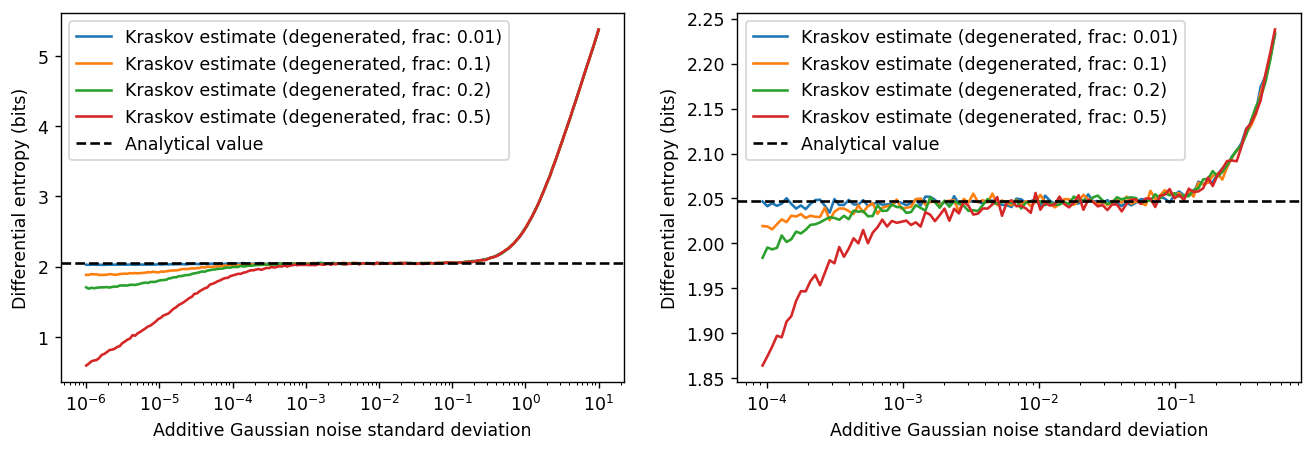

In [7]:
plt.figure(figsize=(2*6.4, 0.8*4.8), dpi=125)

plt.subplot(1, 2, 1)

for frac, hs_degen in zip(fracs, hs_degen_list):
    plt.semilogx(stds, hs_degen, label=f'Kraskov estimate (degenerated, frac: {frac})')
plt.axhline(href, color='black', linestyle='--', label='Analytical value')

plt.xlabel('Additive Gaussian noise standard deviation')
plt.ylabel('Differential entropy (bits)')
plt.legend()

plt.subplot(1, 2, 2)

filt = np.abs(hs_degen - href) < 0.2
for frac, hs_degen in zip(fracs, hs_degen_list):
    plt.semilogx(stds[filt], hs_degen[filt], label=f'Kraskov estimate (degenerated, frac: {frac})')
plt.axhline(href, color='black', linestyle='--', label='Analytical value')

plt.xlabel('Additive Gaussian noise standard deviation')
plt.ylabel('Differential entropy (bits)')
plt.legend()

plt.show()

## Californian housing example

The Californian housing dataset is an interesting example because some features are composed of discrete values (for instance, integers).

In [58]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [59]:
# Log norm
data = housing.data
target = housing.target
for feature in ["AveRooms", "AveBedrms", "Population", "AveOccup"]:
    i = housing.feature_names.index(feature)
    data[:, i] = np.log10( data[:, i] )

In [60]:
d = {}

for i, feature in enumerate(housing.feature_names + housing.target_names):
    
    if i == 8:
        x = housing.target
    else:
        x = housing.data[:, i]
    u, c = np.unique(x, return_counts=True)
    counts = np.bincount(c)

    d.update({feature: counts})

    print(feature)
    print(f"Total number of values: {x.size:,}")
    print(f"Number of unique values: {u.size:,}")
    print(f"Number of duplicates: {x.size-u.size:,} ({100*(1-u.size/x.size):.2f}%)")
    print(f"Highest number of duplicates: {c[-1]} ({counts[-1]} time(s))\n")

MedInc
Total number of values: 20,640
Number of unique values: 12,928
Number of duplicates: 7,712 (37.36%)
Highest number of duplicates: 49 (2 time(s))

HouseAge
Total number of values: 20,640
Number of unique values: 52
Number of duplicates: 20,588 (99.75%)
Highest number of duplicates: 1273 (1 time(s))

AveRooms
Total number of values: 20,640
Number of unique values: 19,392
Number of duplicates: 1,248 (6.05%)
Highest number of duplicates: 1 (1 time(s))

AveBedrms
Total number of values: 20,640
Number of unique values: 14,233
Number of duplicates: 6,407 (31.04%)
Highest number of duplicates: 1 (1 time(s))

Population
Total number of values: 20,640
Number of unique values: 3,888
Number of duplicates: 16,752 (81.16%)
Highest number of duplicates: 1 (1 time(s))

AveOccup
Total number of values: 20,640
Number of unique values: 18,841
Number of duplicates: 1,799 (8.72%)
Highest number of duplicates: 1 (1 time(s))

Latitude
Total number of values: 20,640
Number of unique values: 862
Number 

In [61]:
# for i, feature in enumerate(housing.feature_names):

#     counts = d[feature][1:]
#     nbs = np.arange(len(counts)) + 1

#     plt.figure()

#     plt.pie(counts, labels=nbs)
#     plt.title(f"Number of apparition of values")

#     plt.show()

    # for i, c in enumerate(counts[1:], 1):
    #     if c != 0:
    #         print(f"Count {i}: {c:,} ({100*c/x.size:.2f}%)")

In [62]:
stds = np.logspace(-6, 1, 200)

d_hs = {}
for i, feature in enumerate(housing.feature_names):
    hs = np.zeros_like(stds)
    x = housing.data[:, i].reshape(-1, 1)
    for k, std in enumerate(tqdm(stds, desc=feature)):
        xn = x + np.random.normal(0, std, x.shape)
        hs[k] = ee.entropy(xn, base=base)
    d_hs[feature] = hs

Longitude: 100%|██████████| 200/200 [00:04<00:00, 44.05it/s]


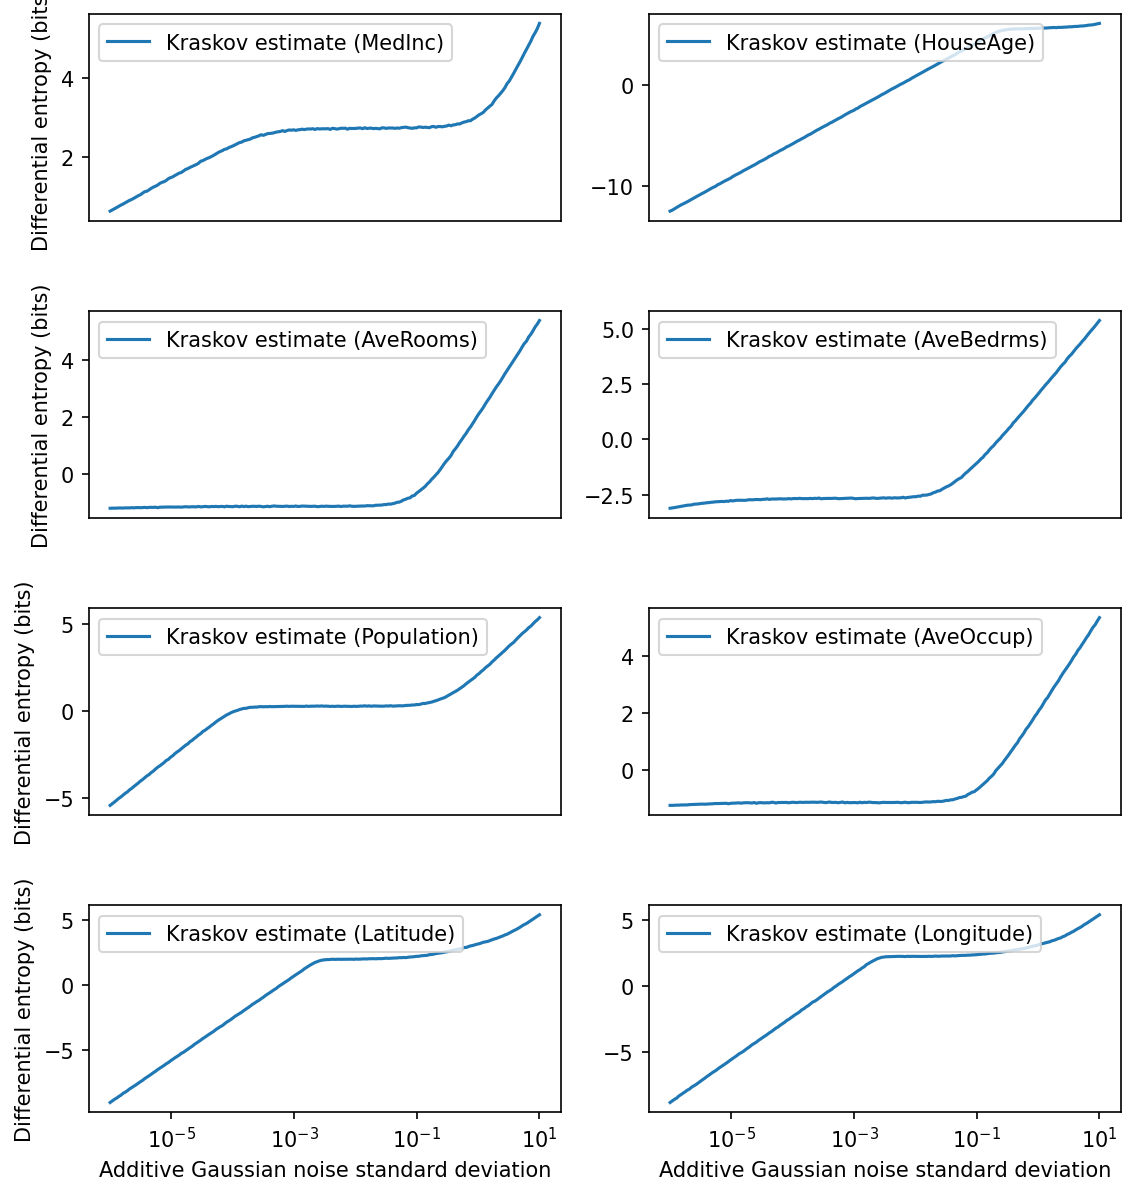

In [63]:
plt.figure(figsize=(1.2*6.4, 2*4.8), dpi=150)

for i, feature in enumerate(housing.feature_names, 1):

    plt.subplot(5, 2, i)

    plt.semilogx(stds, d_hs[feature], label=f'Kraskov estimate ({feature})')

    if i in (7, 8):
        plt.xlabel('Additive Gaussian noise standard deviation')
    else:
        plt.xticks([])
    if i%2==1:
        plt.ylabel('Differential entropy (bits)')
    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### For conditional entropy

In [64]:
stds = np.logspace(-6, 1, 200)

d_condhs = {}
for i, feature in enumerate(housing.feature_names):
    hs = np.zeros_like(stds)
    x = housing.data[:, i].reshape(-1, 1)
    y = housing.target.reshape(-1, 1)
    for k, std in enumerate(tqdm(stds, desc=feature)):
        xn = x + np.random.normal(0, std, x.shape)
        hs[k] = ee.centropy(y, xn, base=base)
    d_condhs[feature] = hs

Longitude: 100%|██████████| 200/200 [00:10<00:00, 19.26it/s]


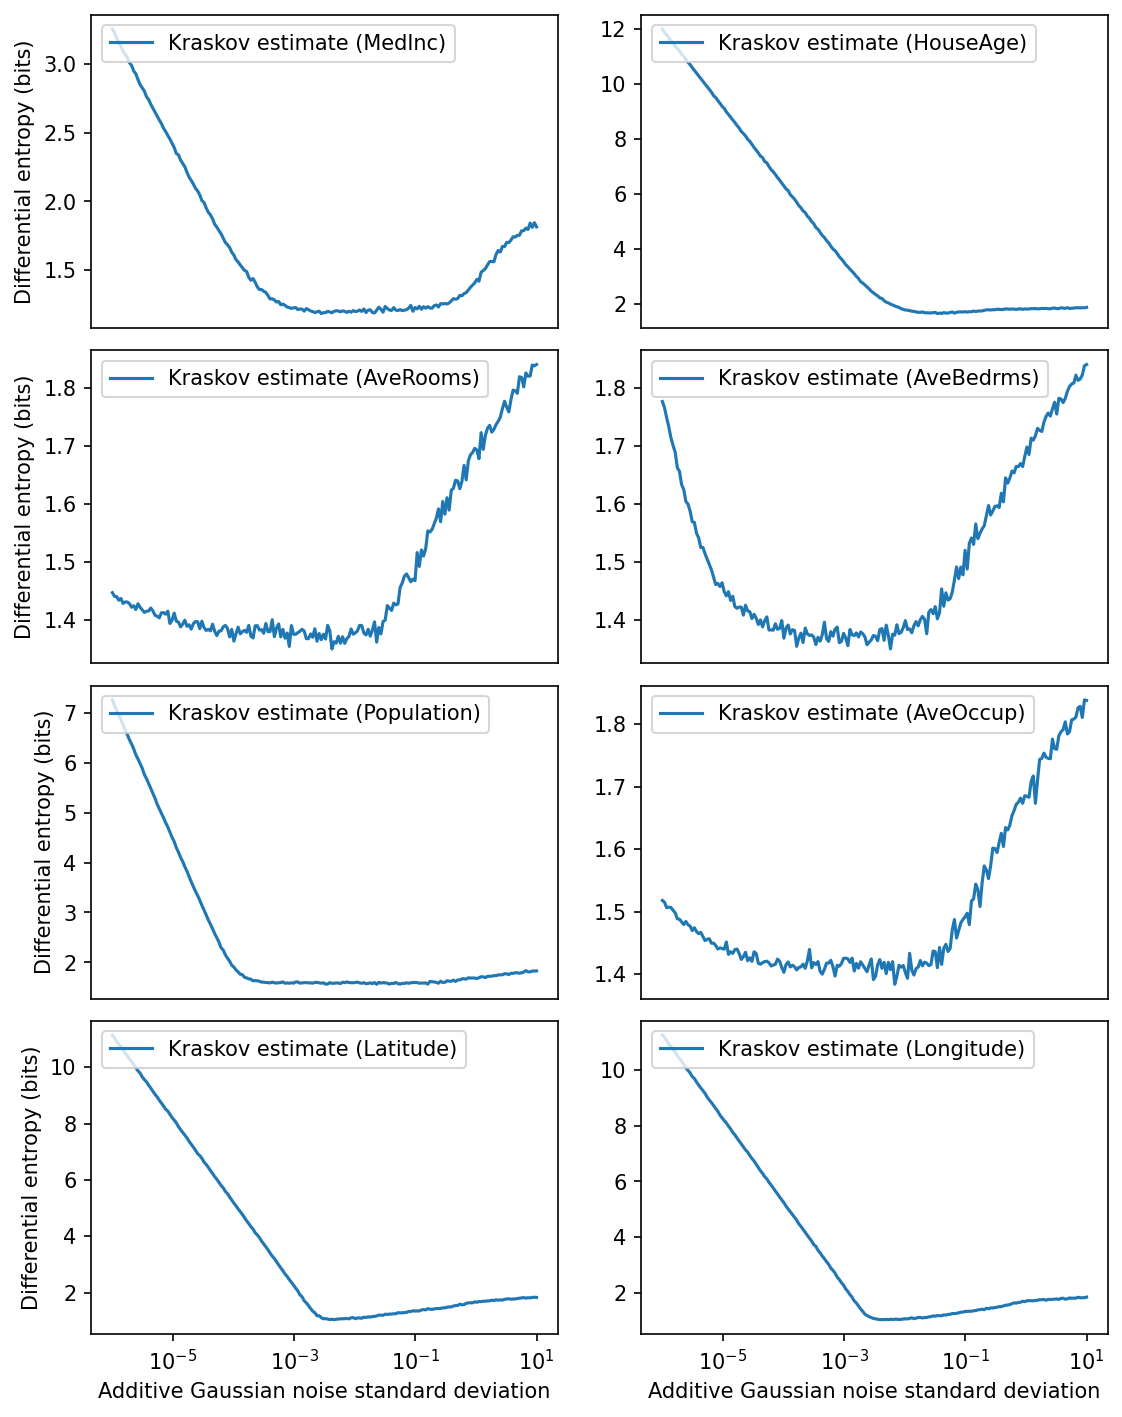

In [65]:
plt.figure(figsize=(1.2*6.4, 2*4.8), dpi=150)

for i, feature in enumerate(housing.feature_names, 1):

    plt.subplot(4, 2, i)

    plt.semilogx(stds, d_condhs[feature], label=f'Kraskov estimate ({feature})')

    if i in (7, 8):
        plt.xlabel('Additive Gaussian noise standard deviation')
    else:
        plt.xticks([])
    if i%2==1:
        plt.ylabel('Differential entropy (bits)')
    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### For mutual information

In [66]:
stds = np.logspace(-6, 1, 200)

d_mis = {}
for i, feature in enumerate(housing.feature_names):
    hs = np.zeros_like(stds)
    x = housing.data[:, i].reshape(-1, 1)
    y = housing.target.reshape(-1, 1)
    for k, std in enumerate(tqdm(stds, desc=feature)):
        xn = x# + np.random.normal(0, std, x.shape)
        yn = y + np.random.normal(0, std, y.shape)
        hs[k] = ee.mi(yn, xn, base=base)
    d_mis[feature] = hs

Longitude: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


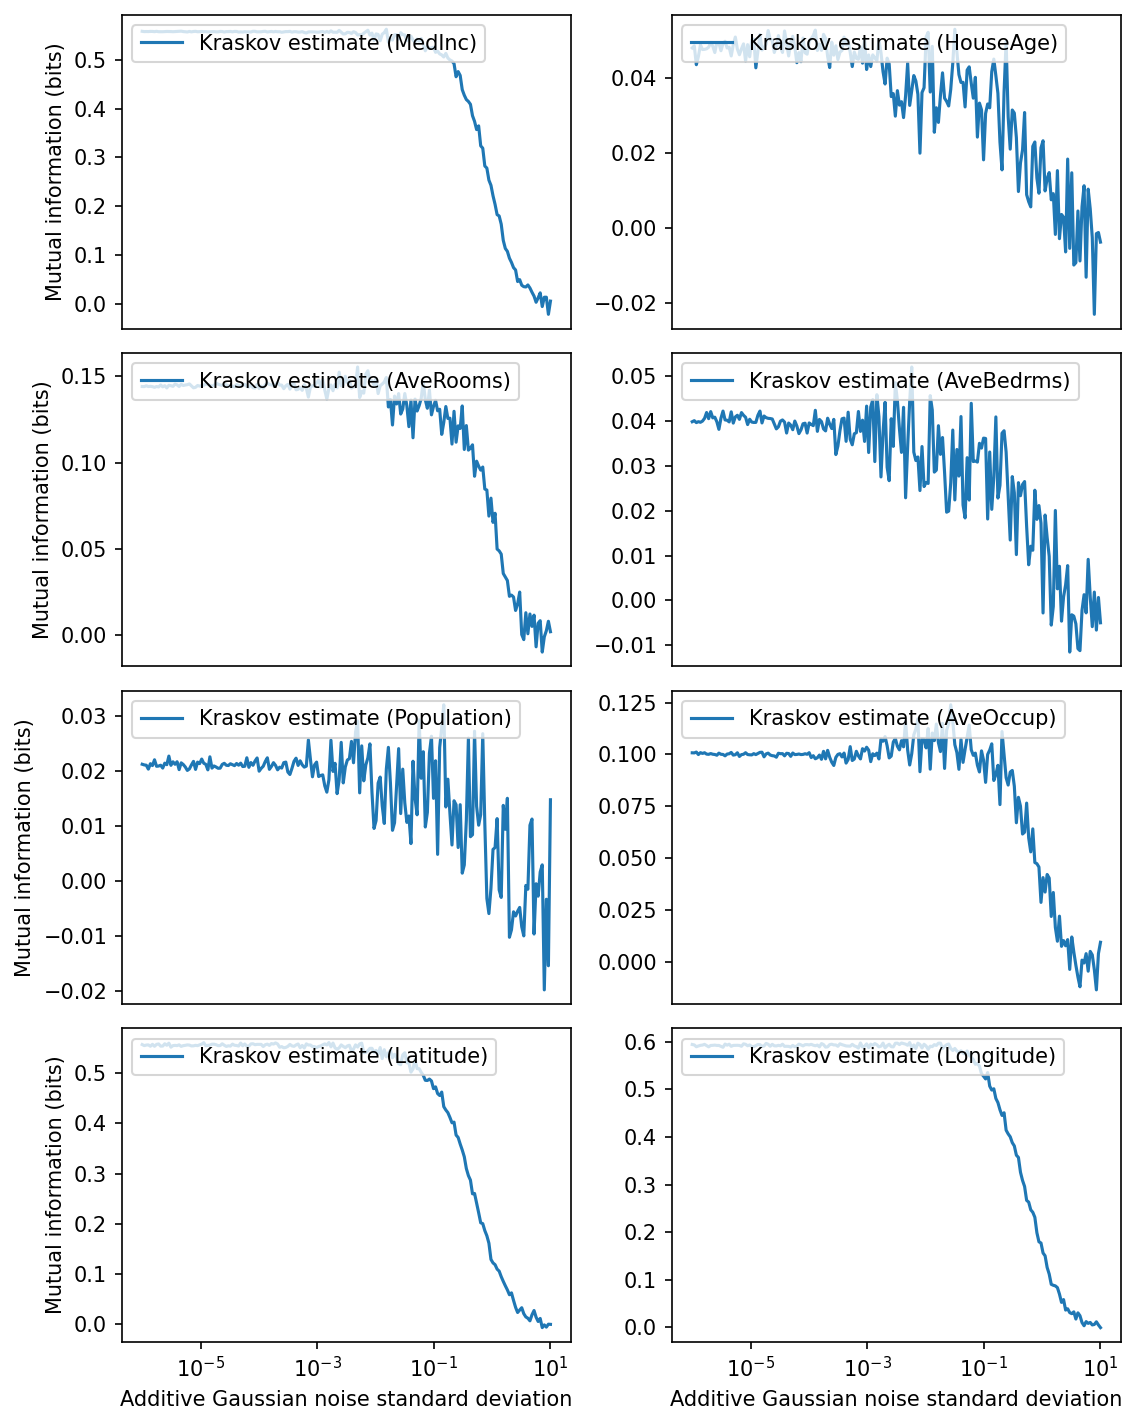

In [67]:
plt.figure(figsize=(1.2*6.4, 2*4.8), dpi=150)

for i, feature in enumerate(housing.feature_names, 1):

    plt.subplot(4, 2, i)

    plt.semilogx(stds, d_mis[feature], label=f'Kraskov estimate ({feature})')

    if i in (7, 8):
        plt.xlabel('Additive Gaussian noise standard deviation')
    else:
        plt.xticks([])
    if i%2==1:
        plt.ylabel('Mutual information (bits)')
    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### Influence of normalization

In [68]:
# Mean-variance norm
data_norm = data.copy()
target_norm = target.copy()
for feature in housing.feature_names:
    i = housing.feature_names.index(feature)
    data_norm[:, i] = (data_norm[:, i] - np.mean(data_norm[:, i])) / np.std(data_norm[:, i])

# target_norm = (target_norm - np.mean(target_norm)) / np.std(target_norm)

In [69]:
stds = np.logspace(-6, 1, 200)

d_condhs = {}
for i, feature in enumerate(housing.feature_names):
    hs = np.zeros_like(stds)
    x = data_norm[:, i].reshape(-1, 1)
    y = target.reshape(-1, 1)
    for k, std in enumerate(tqdm(stds, desc=feature)):
        xn = x + np.random.normal(0, std, x.shape)
        hs[k] = ee.centropy(y, xn, base=base)
    d_condhs[feature] = hs

Longitude: 100%|██████████| 200/200 [00:10<00:00, 19.10it/s]


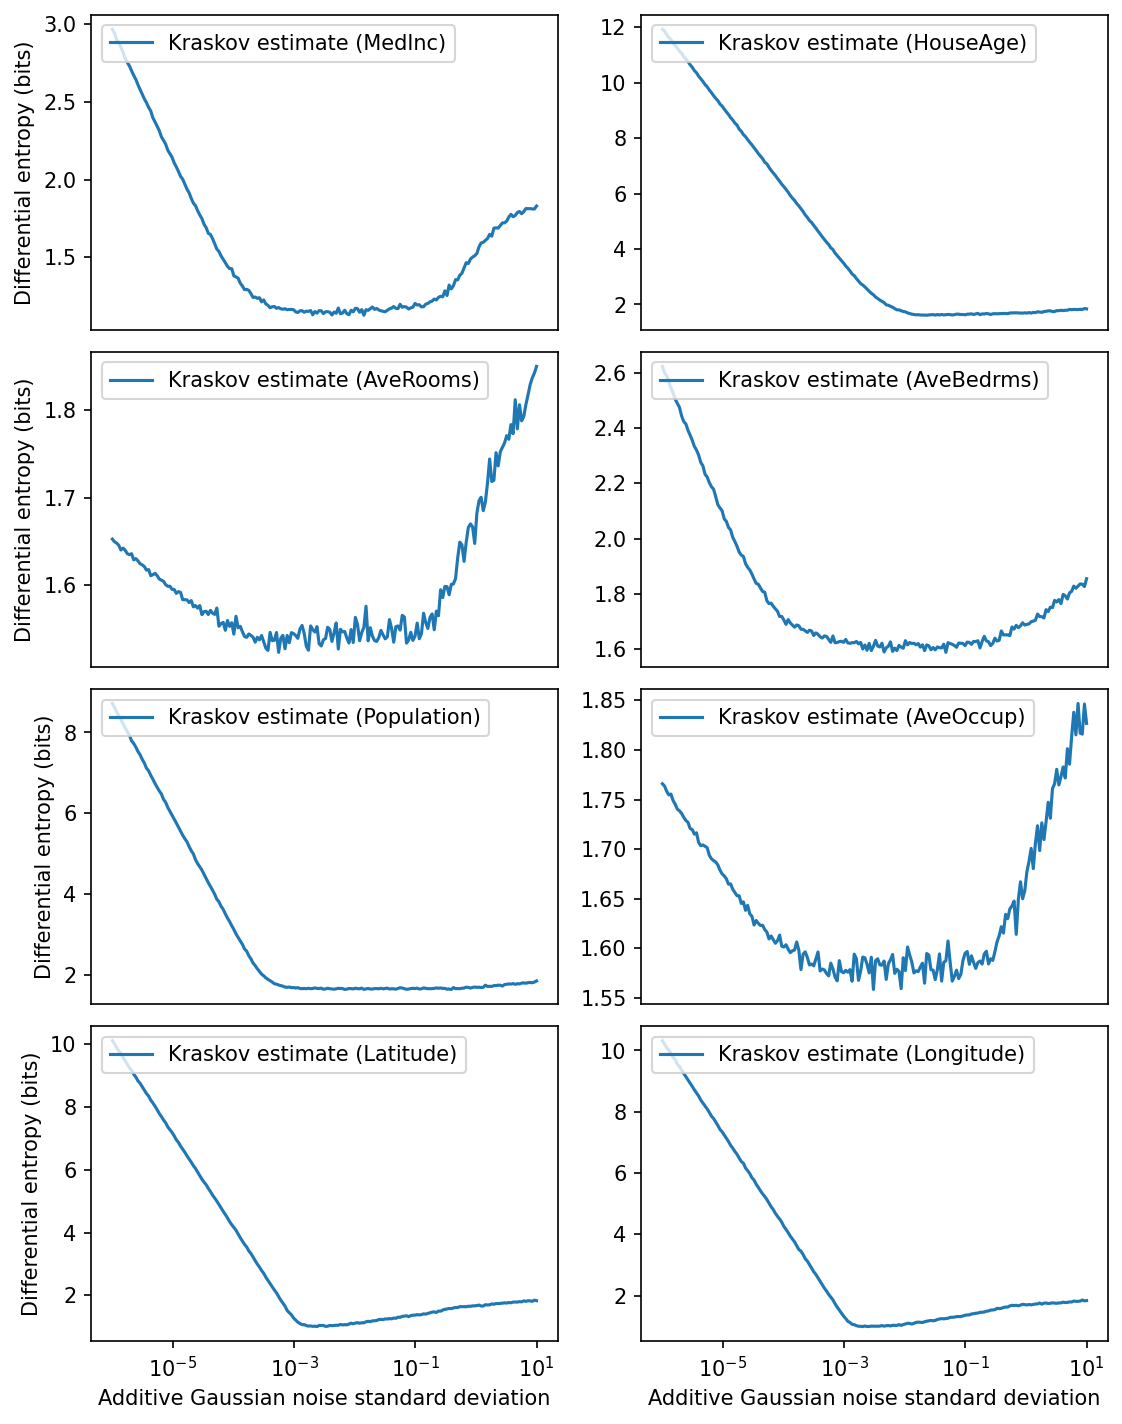

In [70]:
plt.figure(figsize=(1.2*6.4, 2*4.8), dpi=150)

for i, feature in enumerate(housing.feature_names, 1):

    plt.subplot(4, 2, i)

    plt.semilogx(stds, d_condhs[feature], label=f'Kraskov estimate ({feature})')

    if i in (7, 8):
        plt.xlabel('Additive Gaussian noise standard deviation')
    else:
        plt.xticks([])
    if i%2==1:
        plt.ylabel('Differential entropy (bits)')
    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()